# Boosted Decision Tree (BDT) Classifier for Jet Tagging

This section implements a Boosted Decision Tree (BDT) using the GradientBoostingClassifier from scikit-learn to distinguish between QCD background and Higgs → bb signal jets. The input features are derived from jet substructure observables, averaged over jet constituents where necessary. The model is trained and evaluated using labeled datasets with appropriate kinematic selections:

Mass window: 40 GeV < M<sub>sd</sub> < 200 GeV

Transverse momentum: 300 GeV < p<sub>T</sub> < 2000 GeV

Performance is quantified using the Receiver Operating Characteristic (ROC) curve, and the Area Under the Curve (AUC) is used as a metric for discriminating power.

In [1]:
# ====================================================
# I/O and Data Handling
# ====================================================
import fsspec_xrootd                   # Enables ROOT file access via XRootD (remote EOS)
import uproot                          # For reading ROOT files in Python
import awkward as ak                   # For handling jagged arrays (variable-length arrays)
import numpy as np                     # Core numerical operations

# ====================================================
# Utility and Configuration
# ====================================================
import yaml                            # For parsing configuration files (e.g., feature definitions)
import joblib                          # For saving/loading trained scikit-learn models

# ====================================================
# Plotting (CMS style with HEP formatting)
# ====================================================
import matplotlib.pyplot as plt        # Standard plotting
import mplhep as hep                   # CMS/HEP-compatible plotting styles
plt.style.use(hep.style.ROOT)          # Apply ROOT style

# ====================================================
# Custom Utilities
# ====================================================
import utilities.utils as utils        # Your helper functions (e.g., make_image, to_np_array, etc.)

# ====================================================
# Machine Learning Models and Evaluation
# ====================================================
from sklearn.ensemble import GradientBoostingClassifier  # Gradient Boosted Decision Tree model
from sklearn.metrics import accuracy_score, roc_curve, auc  # Evaluation metrics


In [2]:
# Load the definitions
with open('./utilities/definitions_bdt_dnn.yml', 'r') as file:
    definitions = yaml.load(file, Loader = yaml.FullLoader)

features = definitions['features']
spectators = definitions['spectators']
labels = definitions['labels']

nfeatures = definitions['nfeatures']
nspectators = definitions['nspectators']
nlabels = definitions['nlabels']

In [5]:
# ============================================================
# Define ROOT file paths for training and testing datasets
# ============================================================
train_file_path = 'root://eospublic.cern.ch//eos/opendata/cms/datascience/HiggsToBBNtupleProducerTool/HiggsToBBNTuple_HiggsToBB_QCD_RunII_13TeV_MC/train/ntuple_merged_10.root'  # Training data
test_file_path  = 'root://eospublic.cern.ch//eos/opendata/cms/datascience/HiggsToBBNtupleProducerTool/HiggsToBBNTuple_HiggsToBB_QCD_RunII_13TeV_MC/test/ntuple_merged_0.root'  # Testing data (can be different)

# ============================================================
# Load training data (features, labels, and spectators)
# - Applies pT and mass window cuts
# - Also removes unlabeled data internally
# - Entry_stop = 72,000 jets (24000 * 3)
# ============================================================
feature_array, label_array, spec_array = utils.get_features_labels(
    file_name = train_file_path,
    features = features,
    spectators = spectators,
    labels = labels,
    remove_mass_pt_window = True,
    entry_stop = 24000 * 3
)

# ============================================================
# Load test data
# - Entry_stop = 15,000 jets (5000 * 3)
# - Same preprocessing: cuts + labeling
# ============================================================
feature_array_test, label_array_test, spectator_array_test = utils.get_features_labels(
    file_name = test_file_path,
    features = features,
    labels = labels,
    spectators = spectators,
    remove_mass_pt_window = True,
    entry_stop = 5000 * 3
)


In [6]:
# ================================================================
# Convert jagged/awkward arrays into fixed-size float inputs
# by replacing non-float elements with their mean value.
# This ensures compatibility with BDT or DNN models.
# ================================================================

# ----------- Training Data -----------
for j in range(len(feature_array)):
    for i in range(len(feature_array[j])):
        if not isinstance(feature_array[j, i], float):
            # Replace variable-length feature (e.g., a list/array) with its mean
            feature_array[j, i] = np.mean(feature_array[j, i])

# ----------- Testing Data ------------
for j in range(len(feature_array_test)):
    for i in range(len(feature_array_test[j])):
        if not isinstance(feature_array_test[j, i], float):
            # Same conversion for test set
            feature_array_test[j, i] = np.mean(feature_array_test[j, i])


In [7]:
# ================================================================
# Train a Gradient Boosting Classifier (GBC) on processed features
# Target: label_array[:, 1] → 1 for H→bb (signal), 0 for QCD (background)
# ================================================================

from sklearn.ensemble import GradientBoostingClassifier

# Instantiate the classifier
gbc_model = GradientBoostingClassifier(max_depth=5)

# Fit model on training data
# - Input: feature_array (shape: [n_samples, n_features])
# - Target: label_array[:, 1] (binary class: 1 = H→bb, 0 = QCD)
gbc_model.fit(feature_array, label_array[:, 1])


GradientBoostingClassifier(max_depth=5)

In [8]:
# =================================================================
# Save the trained BDT model using joblib (uncomment to use)
# =================================================================

from joblib import dump
dump(gbc_model, './trained_models/new_models/trained_bdt_model.pkl')


# =================================================================
# Load the trained BDT model from disk (if already saved)
# =================================================================

# from joblib import load
# model = load('./trained_models/trained_bdt_model.pkl')


['./trained_models/new_models/trained_bdt_model.pkl']

In [9]:
# ================================================================
# Make predictions on the test dataset using the trained BDT model
# ================================================================

gbc_predict = gbc_model.predict(feature_array_test)

# ================================================================
# Evaluate accuracy against true labels (1 = H→bb, 0 = QCD)
# ================================================================

from sklearn.metrics import accuracy_score

accuracy = accuracy_score(gbc_predict, label_array_test[:, 1])

print(f"Using Gradient Boosting Classifier, the test accuracy is: {accuracy * 100:.2f}%")


Using Gradient Boosting Classifier, the test accuracy is: 90.02%


In [10]:
# ================================================================
# Predict class probabilities for the test set using the BDT model
# We extract the probability of the positive class (H→bb)
# ================================================================
predict_array_gbc = gbc_model.predict_proba(feature_array_test)[:, 1]

# ================================================================
# Compute ROC curve components: FPR, TPR, thresholds
# - FPR: False Positive Rate
# - TPR: True Positive Rate
# - threshold_gbc: decision threshold values
# ================================================================
from sklearn.metrics import roc_curve

fpr_gbc, tpr_gbc, threshold_gbc = roc_curve(label_array_test[:, 1], predict_array_gbc)


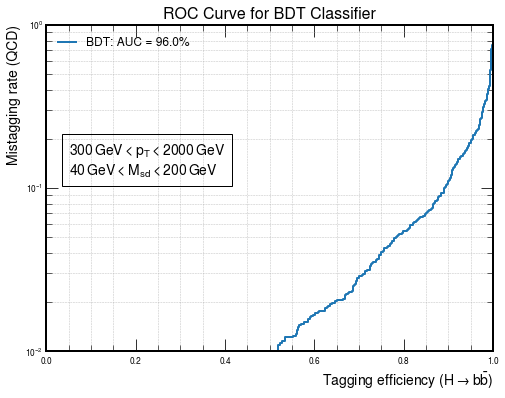

In [11]:
# ============================================================
# Plot ROC Curve for BDT (Gradient Boosting Classifier)
# ============================================================

plt.figure(figsize=(8, 6))

# Plot TPR vs FPR (note: FPR is on log scale)
plt.plot(tpr_gbc, fpr_gbc, label=f'BDT: AUC = {auc(fpr_gbc, tpr_gbc)*100:.1f}%', linewidth=2)

# Axis labeling with physics context
plt.xlabel(r'Tagging efficiency $(H \to b\bar{b})$', fontsize=14)
plt.ylabel(r'Mistagging rate (QCD)', fontsize=14)

# Set log scale for Y-axis
plt.semilogy()

# Set axis limits
plt.xlim(0, 1)
plt.ylim(0.01, 1)

# Enable minor grid for better log scale readability
plt.grid(True, which='minor', linestyle='--', linewidth=0.5)

# Add legend in the upper-left corner
plt.legend(loc='upper left', fontsize=12)

# Add annotation box for mass and pT cuts
label_text = r'$300\,\mathrm{GeV} < p_T < 2000\,\mathrm{GeV}$' + '\n' + r'$40\,\mathrm{GeV} < M_{sd} < 200\,\mathrm{GeV}$'
plt.text(0.05, 0.12, label_text,
         fontsize=14,
         bbox=dict(facecolor='none', edgecolor='black', boxstyle='square,pad=0.5'))

# Show the plot
plt.title('ROC Curve for BDT Classifier', fontsize=16)
plt.show()
